# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [4]:
X_train_feats[0]

array([ 3.54119526e-01, -1.72052664e-01, -1.89323704e-01, -4.17862613e-01,
       -3.94481327e-01,  4.48531849e-01,  2.84295588e+00,  4.19451498e-01,
       -2.74761161e-01, -2.46967211e-01, -5.08199451e-01, -5.81640785e-01,
       -5.81971495e-02, -7.08449281e-01, -8.01912898e-01, -4.75529745e-01,
       -2.85409897e-01, -1.05932426e-01, -4.60329249e-01,  1.31838018e+00,
       -6.02347714e-03, -1.55236480e-01,  2.73182901e-01,  2.34528881e-01,
        4.80789274e+00,  5.64193546e-02, -6.66260565e-01,  1.84123394e-01,
       -4.98833272e-01, -1.39829840e-01,  2.30407394e-03, -2.76522002e-01,
       -5.86681488e-01,  3.48191989e-02, -8.18975569e-02, -4.31122324e-01,
       -1.93680246e-01, -1.98940760e-01, -6.68478883e-01, -1.03501003e-01,
        3.88838504e-01, -1.14982418e-01, -3.40533865e-01, -5.11713595e-01,
       -4.23046544e-01, -8.63151892e-01,  1.08827888e-01, -9.15910804e-01,
       -5.58153107e-01,  4.07823767e-01,  2.55730627e+00,  3.50727176e+00,
        1.42116434e+00,  

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [10e-2, 5e-2, 3e-2, 1e-2]
regularization_strengths = [1e-2, 1e-1, 1e1]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

iters = [1500]
total_size = len(learning_rates) * len(regularization_strengths)
i = 0
for lr in learning_rates:
    for rs in regularization_strengths:
        for iter_size in iters:
            i += 1
            print(i, '/', total_size)
            svm = LinearSVM()
            # Train the network
            stats = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs, num_iters=iter_size, verbose=False)
            y_train_pred = svm.predict(X_train_feats)
            acc_train = np.mean(y_train == y_train_pred)
            y_val_pred = svm.predict(X_val_feats)
            acc_val = np.mean(y_val == y_val_pred)
            results[(lr, rs, iter_size)] = (acc_train, acc_val)
            if best_val < acc_val:
                best_stats = stats
                best_val = acc_val
                best_svm = svm

# Print out results.
sorted_results = sorted(results.items(), key=lambda kv: kv[1], reverse=True)
for param, res in sorted_results:
    lr, reg, iter_size = param
    train_accuracy, val_accuracy = res
    print('lr %e reg %e iter %e train accuracy: %f val accuracy: %f' % (
                lr, reg, iter_size, train_accuracy, val_accuracy))
print('best validation accuracy achieved during cross-validation: %f' % best_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
#for lr, reg in sorted(results):
#    train_accuracy, val_accuracy = results[(lr, reg)]
#    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
#                lr, reg, train_accuracy, val_accuracy)
#    
#print 'best validation accuracy achieved during cross-validation: %f' % best_val

1 / 12
2 / 12
3 / 12
4 / 12
5 / 12
6 / 12
7 / 12
8 / 12
9 / 12
10 / 12
11 / 12
12 / 12
lr 1.000000e-02 reg 1.000000e-02 iter 1.500000e+03 train accuracy: 0.508735 val accuracy: 0.485000
lr 1.000000e-02 reg 1.000000e-01 iter 1.500000e+03 train accuracy: 0.507327 val accuracy: 0.488000
lr 3.000000e-02 reg 1.000000e-02 iter 1.500000e+03 train accuracy: 0.502286 val accuracy: 0.496000
lr 3.000000e-02 reg 1.000000e-01 iter 1.500000e+03 train accuracy: 0.497306 val accuracy: 0.486000
lr 5.000000e-02 reg 1.000000e-02 iter 1.500000e+03 train accuracy: 0.491245 val accuracy: 0.496000
lr 5.000000e-02 reg 1.000000e-01 iter 1.500000e+03 train accuracy: 0.487224 val accuracy: 0.482000
lr 1.000000e-01 reg 1.000000e-02 iter 1.500000e+03 train accuracy: 0.483633 val accuracy: 0.497000
lr 1.000000e-01 reg 1.000000e-01 iter 1.500000e+03 train accuracy: 0.472204 val accuracy: 0.453000
lr 1.000000e-02 reg 1.000000e+01 iter 1.500000e+03 train accuracy: 0.437469 val accuracy: 0.445000
lr 3.000000e-02 reg 1.

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.465


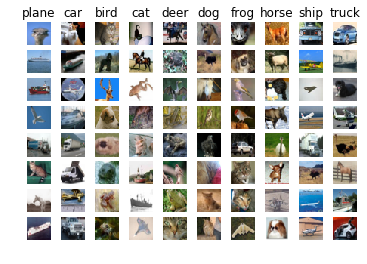

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Answer:
Error images' backgroud would be similar to answer class

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10


best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_val = -1
best_stats = None
learning_rates = [1e-1, 5e-1, 3e-1]
regularization_strengths = [1e1, 1, 1e-1, 1e-2, 1e-3]
batch_sizes = [800] # [200, 400, 800]
results = {}
iters = 1500
total_size = len(learning_rates) * len(regularization_strengths) * len(batch_sizes)
i = 0
for lr in learning_rates:
    for rs in regularization_strengths:
        for bs in batch_sizes:
                hs = hidden_dim
                i += 1
                print(i, '/', total_size)
                net = TwoLayerNet(input_dim, hs, num_classes)
                # Train the network
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                            num_iters=iters, batch_size=bs,
                            learning_rate=lr, learning_rate_decay=0.95, 
                            reg=rs)
                y_train_pred = net.predict(X_train_feats)
                acc_train = np.mean(y_train == y_train_pred)
                y_val_pred = net.predict(X_val_feats)
                acc_val = np.mean(y_val == y_val_pred)
                results[(lr, rs, bs, hs)] = (acc_train, acc_val)
                if best_val < acc_val:
                    best_stats = stats
                    best_val = acc_val
                    best_net = net
# Print out results.
sorted_results = sorted(results.items(), key=lambda kv: kv[1], reverse=True)
for param, res in sorted_results:
    lr, reg, bs, hs = param
    train_accuracy, val_accuracy = res
    print('lr %e reg %e bs %e hs %e train accuracy: %f val accuracy: %f' % (
                lr, reg, bs, hs, train_accuracy, val_accuracy))
print('best validation accuracy achieved during cross-validation: %f' % best_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15


/workspace/project/cs231n/upload/cs231n/assignment1/cs231n/classifiers/neural_net.py:105: RuntimeWarning: divide by zero encountered in log
  h2 = -np.log(np.exp(correct_scores) / np.sum(np.exp(s2), axis=1))
/workspace/project/cs231n/upload/cs231n/assignment1/cs231n/classifiers/neural_net.py:103: RuntimeWarning: overflow encountered in subtract
  s2 -= np.matrix(s2.max(axis=1)).T   # stable softmax
/workspace/project/cs231n/upload/cs231n/assignment1/cs231n/classifiers/neural_net.py:103: RuntimeWarning: invalid value encountered in subtract
  s2 -= np.matrix(s2.max(axis=1)).T   # stable softmax
/workspace/project/cs231n/upload/cs231n/assignment1/cs231n/classifiers/neural_net.py:108: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W1 * W1)
/workspace/project/cs231n/upload/cs231n/assignment1/cs231n/classifiers/neural_net.py:109: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W2 * W2)
/usr/local/lib/python3.6/dist-pac

7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
lr 5.000000e-01 reg 1.000000e-03 bs 8.000000e+02 hs 5.000000e+02 train accuracy: 0.712265 val accuracy: 0.605000
lr 3.000000e-01 reg 1.000000e-03 bs 8.000000e+02 hs 5.000000e+02 train accuracy: 0.650102 val accuracy: 0.608000
lr 5.000000e-01 reg 1.000000e-02 bs 8.000000e+02 hs 5.000000e+02 train accuracy: 0.585265 val accuracy: 0.554000
lr 3.000000e-01 reg 1.000000e-02 bs 8.000000e+02 hs 5.000000e+02 train accuracy: 0.566878 val accuracy: 0.545000
lr 1.000000e-01 reg 1.000000e-03 bs 8.000000e+02 hs 5.000000e+02 train accuracy: 0.543673 val accuracy: 0.536000
lr 1.000000e-01 reg 1.000000e-02 bs 8.000000e+02 hs 5.000000e+02 train accuracy: 0.532102 val accuracy: 0.516000
lr 5.000000e-01 reg 1.000000e-01 bs 8.000000e+02 hs 5.000000e+02 train accuracy: 0.443327 val accuracy: 0.442000
lr 3.000000e-01 reg 1.000000e-01 bs 8.000000e+02 hs 5.000000e+02 train accuracy: 0.441694 val accuracy: 0.431000
lr 1.000000e-01 reg 1.00000

In [9]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.
net = best_net
test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.576


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!